# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Homework 8: Ensembles: Bagging, Random Forests, and Boosting


**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the [instructions given in Canvas](https://canvas.harvard.edu/courses/42693/pages/homework-policies-and-submission-instructions).

- If needed, clarifications will be posted on Piazza.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below. 


**Name of the person you have worked with goes here:**
<br><BR>

## Learning Objectives
Completing this assignment will demonstrate success at the following objectives:

- Statistical
  - Predict when bagging will help model performance.
  - Identify how Random Forests improve over bagging.
  - Predict when boosting will help model performance.
  - Compare and contrast bagging and boosting.
- Coding
  - Identify and fix problems in poorly written code
- Communication
  - Visually explain a complex concept

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

<div class="theme"> Overview: Higgs Boson Discovery </div>

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between collisions that produce Higgs bosons and collisions that produce only background noise. We shall explore the use of ensemble methods for this classification task.

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle collision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background).

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: [Baldi et al., Nature Communications 5, 2014](https://www.nature.com/articles/ncomms5308).

In [4]:
# Load data
data_train = pd.read_csv('data/Higgs_train.csv')
data_test = pd.read_csv('data/Higgs_test.csv')

print(f"{len(data_train)} training samples, {len(data_test)} test samples")
print("\nColumns:")
print(', '.join(data_train.columns))

5000 training samples, 5000 test samples

Columns:
lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb, class


In [5]:
display(data_train.head())
display(data_train.describe())

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.377,-1.5800,-1.7100,0.991,0.114,1.250,0.620,-1.480,2.17,0.754,0.7750,-0.667,2.21,1.280,-1.190,0.505,0.00,1.110,-0.464,0.397,0.00,0.522,1.320,0.982,1.360,0.965,1.310,1.080,1.0
1,0.707,0.0876,-0.4000,0.919,-1.230,1.170,-0.553,0.886,2.17,1.300,0.7620,-1.060,2.21,0.607,0.459,1.020,0.00,0.497,0.956,0.236,0.00,0.440,0.829,0.992,1.160,2.220,1.190,0.938,1.0
2,0.617,0.2660,-1.3500,1.150,1.040,0.955,0.377,-0.148,0.00,1.060,-0.0194,1.110,0.00,1.470,0.205,-1.060,2.55,1.490,-0.398,-0.542,0.00,1.020,1.030,0.986,0.928,1.370,0.982,0.917,1.0
3,0.851,-0.3810,-0.0713,1.470,-0.795,0.692,0.883,0.497,0.00,1.620,0.1240,1.180,1.11,1.290,0.160,-0.916,2.55,0.945,0.796,-1.520,0.00,1.200,1.100,0.987,1.350,1.460,0.995,0.954,1.0
4,0.768,-0.6920,-0.0402,0.615,0.144,0.749,0.397,-0.874,0.00,1.150,0.1270,1.320,2.21,0.730,-0.758,-1.120,0.00,0.848,0.107,0.502,1.55,0.922,0.864,0.983,1.370,0.601,0.919,0.957,0.0


,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.978645,-0.014280,-0.018956,1.005793,0.002528,0.980390,0.025014,-0.007104,0.993678,0.988659,-0.010310,-0.006926,1.006922,0.997004,0.018817,0.003952,1.011994,0.982806,0.005201,0.003349,1.007810,1.038431,1.027201,1.054719,1.023094,0.958464,1.033432,0.960494,0.524600
std,0.547025,1.011927,0.997945,0.591907,1.003337,0.463677,1.002018,1.014559,1.028920,0.476462,1.007983,1.002177,1.045206,0.471681,1.007824,0.999656,1.200416,0.497681,1.007999,1.008904,1.400846,0.619460,0.353984,0.173243,0.427141,0.495720,0.352966,0.306057,0.499444
min,0.275000,-2.410000,-1.740000,0.010000,-1.740000,0.170000,-2.920000,-1.740000,0.000000,0.198000,-2.910000,-1.740000,0.000000,0.265000,-2.720000,-1.740000,0.000000,0.366000,-2.500000,-1.740000,0.000000,0.151000,0.443000,0.339000,0.371000,0.079500,0.413000,0.452000,0.000000
25%,0.587000,-0.764250,-0.877500,0.581000,-0.870000,0.676000,-0.659250,-0.885000,0.000000,0.666000,-0.699000,-0.859500,0.000000,0.664750,-0.679250,-0.858000,0.000000,0.619000,-0.707250,-0.869250,0.000000,0.798750,0.850000,0.986000,0.768000,0.672000,0.826000,0.772750,0.000000
50%,0.846000,-0.009305,-0.016050,0.903500,0.001300,0.891000,0.049500,-0.023500,1.090000,0.891000,-0.004800,-0.030700,1.110000,0.899500,0.045700,0.018800,0.000000,0.877000,0.012900,-0.004700,0.000000,0.898000,0.957000,0.990000,0.922000,0.868000,0.952000,0.877500,1.000000
75%,1.220000,0.725500,0.837000,1.300000,0.866000,1.160000,0.716000,0.894000,2.170000,1.192500,0.692250,0.855500,2.210000,1.232500,0.717000,0.855000,2.550000,1.220000,0.719000,0.859000,3.100000,1.030000,1.090000,1.030000,1.160000,1.120000,1.140000,1.060000,1.000000
max,5.330000,2.430000,1.740000,6.260000,1.740000,4.190000,2.960000,1.740000,2.170000,4.800000,2.910000,1.740000,2.210000,4.630000,2.730000,1.740000,2.550000,5.770000,2.490000,1.740000,3.100000,10.600000,5.740000,3.940000,6.220000,5.080000,4.320000,3.500000,1.000000


In [6]:
# Split into NumPy arrays
X_train = data_train.iloc[:, data_train.columns != 'class'].values
y_train = data_train['class'].values
X_test = data_test.iloc[:, data_test.columns != 'class'].values
y_test = data_test['class'].values

<div class="exercise"> <b> Question 1: A Single Model [20 pts]</b> </div>

We start by fitting a basic model we can compare the other models to. We'll pick a decision tree as the base model, because we'll later include random forests and want a fair comparison. We'll tune the decision tree using cross-validation. As usual, we'll be tuning the maximum tree depth; we refer to this parameter as "depth" for simplicity.

Since we will only be using tree-based methods in this homework, we do not need to standardize or normalize the predictors.

**1.1**: Fit a decision tree model to the training set. Choose a range of tree depths to evaluate. Plot the estimated performance +/- 2 standard deviations for each depth using 5-fold cross validation. Also include the training set performance in your plot, but set the y-axis to focus on the cross-validation performance.

best tree depth = 5


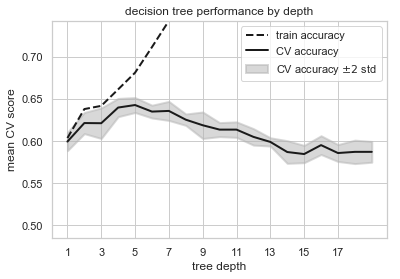

In [26]:
# define depths to test
depths = np.arange(1,20,1)
avg_score = np.empty(depths.shape, dtype=float)
std_score = avg_score.copy()
train_score = avg_score.copy()

# fit decision tree at each depth and record accuracy
for i, depth in enumerate(depths):
    
    # initialize tree at current depth
    clf = DecisionTreeClassifier(criterion="gini", max_depth=depth).fit(X_train,y_train)
    
    # record accuracies
    cv_score = cross_val_score(clf, X_train, y_train, cv=5)
    avg_score[i] = cv_score.mean()
    std_score[i] = cv_score.std()
    train_score[i] = clf.score(X_train, y_train)

# plot the training score, cv score, and std. deviation 
plt.plot(depths, train_score, color='k', lw=2, ls='--', label="train accuracy")
plt.plot(depths, avg_score, color='k', lw=2, label="CV accuracy")
plt.fill_between(depths, avg_score+std_score, avg_score-std_score,\
                 color=(.7,.7,.7), lw=2, alpha=0.5, label="CV accuracy $\pm2$ std")

# configure axes labels/legends
ax = plt.gca()
ax.set_ylim([avg_score.min()-.1,avg_score.max()+.1])
ax.legend()
ax.set_xlabel("tree depth")
ax.set_ylabel("mean CV score")
ax.set_xticks(np.arange(1,depths.max(),2))
ax.set_title("decision tree performance by depth")

# print best tree depth
print("best tree depth = {}".format(depths[np.argmax(avg_score)]))

**1.2** Select an appropriate depth and justify your choice. Using your cross-validation estimates, report the mean +/- 2 stdev. Then report the classification accuracy on the test set. (Store the training and test accuracies in variables to refer to in a later question.)

From the previous question, we receive the highest cross-validation accuracy at a depth of 5. So I will use a depth of 5 moving forward.

In [36]:
# get index of max score and print score and std dev
d_idx = np.argmax(avg_score)
print("The CV accuracy at depth={0} is {1:.2f} +-{2:.2f}"\
      .format(depths[d_idx],avg_score[d_idx],std_score[d_idx]))

The CV accuracy at depth=5 is 0.64 +-0.01


In [144]:
# compute and store test accuracy
best_clf = DecisionTreeClassifier(criterion="gini", max_depth=5).fit(X_train,y_train)

# record accuracies
test_acc = best_clf.score(X_test,y_test)
train_acc = best_clf.score(X_train,y_train)
print("Test accuracy = {0:.2f}".format(test_acc))

Test accuracy = 0.65


**1.3** What is the mechanism by which limiting the depth of the tree avoids over-fitting? What is one downside of limiting the tree depth? Your answer should refer to the bias-variance trade-off.

In a mechanistic sense, limiting the tree depth limits the number of times we can sub-divide the data based on our predictors. If we think about this process in terms of our feature space, it limits the number of little "chunks" we can separate the data into. If we allow the tree to go deep enough, we will eventually reach a point where every data point from the training set is in it's own leaf node with the correct classification. The problem of course is that these tiny little sub-divisions will most likely not reflect the structure of our test data, and therefore the test accuracy will decrease. In terms of bias and variance, a very deep tree will have low bias with respect to the training set but will have high variance  in the structure of the tree across different training sets (ie. low bias, high variance). The downside of limiting the tree depth is that we will most likely have high bias (meaning it will not perform as acurrately on the training data) and lower variance (meaning the model will be more stable across different training data sets).

<div class="exercise"> <b> Question 2: Bagging [25 pts]</b> </div>

Bagging is the technique of building the same model on multiple bootstraps from the data and combining each model's prediction to get an overall classification. In this question we build an example by hand and study how the number of bootstrapped datasets impacts the accuracy of the resulting classification.

**Answers**:

**2.1** Choose a tree depth that will overfit the training set. What evidence leads you to believe that this depth will overfit? Assign your choice to a variable here. (You may want to explore different settings for this value in the problems below.)

To find a model that it overfit, we could look for any model where the CV accuracy score is lower than the training accuracy. If we really want to be sure it's way overfit, we can just choose the minimal depth where the training accuracy is perfect.

In [93]:
# look at the train accuracies from Q1.1 to find overfit model depth
[print("depth = {0},\t train_acc = {1:.3f},\t cv_acc = {2:.3f}".format(d,a,s)) \
 for d,a,s in zip(depths,train_score,avg_score)];

depth = 1,	 train_acc = 0.604,	 cv_acc = 0.599
depth = 2,	 train_acc = 0.638,	 cv_acc = 0.621
depth = 3,	 train_acc = 0.642,	 cv_acc = 0.621
depth = 4,	 train_acc = 0.661,	 cv_acc = 0.640
depth = 5,	 train_acc = 0.681,	 cv_acc = 0.643
depth = 6,	 train_acc = 0.712,	 cv_acc = 0.635
depth = 7,	 train_acc = 0.743,	 cv_acc = 0.636
depth = 8,	 train_acc = 0.780,	 cv_acc = 0.625
depth = 9,	 train_acc = 0.819,	 cv_acc = 0.619
depth = 10,	 train_acc = 0.857,	 cv_acc = 0.614
depth = 11,	 train_acc = 0.893,	 cv_acc = 0.614
depth = 12,	 train_acc = 0.927,	 cv_acc = 0.605
depth = 13,	 train_acc = 0.950,	 cv_acc = 0.599
depth = 14,	 train_acc = 0.968,	 cv_acc = 0.587
depth = 15,	 train_acc = 0.981,	 cv_acc = 0.585
depth = 16,	 train_acc = 0.990,	 cv_acc = 0.595
depth = 17,	 train_acc = 0.997,	 cv_acc = 0.586
depth = 18,	 train_acc = 0.998,	 cv_acc = 0.587
depth = 19,	 train_acc = 1.000,	 cv_acc = 0.587


In [133]:
# define overfit depth
overfit_depth = 16
overfit_tree = DecisionTreeClassifier(criterion="gini", max_depth=overfit_depth).fit(X_train,y_train)
overfit__train_acc = overfit_tree.score(X_train,y_train)
overfit__test_acc = overfit_tree.score(X_test,y_test)

From the accuracies above, I'll tentatively choose a depth of 16 since that's where it first reaches 99% accuracy. Realistically, any depth significantly over 5 is likely to be overfit. As noted in the prompt above, we may want to change this depth value later.

**2.2** Create 45 bootstrapped replications of the original training data, and fit a decision tree to each. Use the tree depth you just chose in 2.1. Record each tree's prediction. In particular, produce a dataset like those below, where each row is a training (or test) example, each column is one of the trees, and each entry is that tree's prediction for that example. (Labeling the rows and columns is optional.)

Store these results as `bagging_train` and `bagging_test`. Don't worry about visualizing these results yet.

**Hints**
- Use `resample` from sklearn to easily bootstrap the x and y data.
- use `np.mean` to easily test for majority. If a majority of models vote 1, what does that imply about the mean?

**Structure of `bagging_train` and `bagging_test`:**

`bagging_train`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 45's prediction|
| --- | --- | --- | --- |
|training row 1| binary value | binary value|... |binary value|
|training row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |

`bagging_test`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 45's prediction|
| --- | --- | --- | --- |
|test row 1| binary value | binary value|... |binary value|
|test row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |


Let's start by defining a function that will resample the data, fit a model to the bootstrapped data, and output the model.

In [49]:
def bootstrap_tree(x, y, tree_depth):
    
    # bootstrap resample the training data (with replacement)
    x_bs, y_bs = resample(x,y)
    
    # fit decision tree to bootstrapped data
    bs_clf = DecisionTreeClassifier(criterion="gini", max_depth=tree_depth).fit(x_bs,y_bs)
    return(bs_clf)

In [50]:
# define num replicates and iterate over replicates to generate bootstrapped models
n_reps = 45
bs_trees = [bootstrap_tree(X_train, y_train, overfit_depth) for i in range(n_reps)]

In [76]:
# initialize placeholders for prediction results
train_pred = np.empty((X_train.shape[0],n_reps), dtype=bool)
test_pred = np.empty((X_train.shape[0],n_reps), dtype=bool)

# iterate over models and record predictions
for i, tree in enumerate(bs_trees):
    train_pred[:,i]=tree.predict(X_train)
    test_pred[:,i]=tree.predict(X_test)
    
# initialize new dataframes to hold bagging train/test predictions
col_names = ['tree_%i_pred' % (i+1) for i in range(n_reps)]
row_idx = ['train_row_%i' % (i+1) for i in range(X_train.shape[0])]
bagging_train = pd.DataFrame(columns=col_names, index=row_idx, data=train_pred)
bagging_test = pd.DataFrame(columns=col_names, index=row_idx, data=test_pred)

In [77]:
# preview the dataframe contents
bagging_train.head(3)

,tree_1_pred,tree_2_pred,tree_3_pred,tree_4_pred,tree_5_pred,tree_6_pred,tree_7_pred,tree_8_pred,tree_9_pred,tree_10_pred,tree_11_pred,tree_12_pred,tree_13_pred,tree_14_pred,tree_15_pred,tree_16_pred,tree_17_pred,tree_18_pred,tree_19_pred,tree_20_pred,tree_21_pred,tree_22_pred,tree_23_pred,tree_24_pred,tree_25_pred,tree_26_pred,tree_27_pred,tree_28_pred,tree_29_pred,tree_30_pred,tree_31_pred,tree_32_pred,tree_33_pred,tree_34_pred,tree_35_pred,tree_36_pred,tree_37_pred,tree_38_pred,tree_39_pred,tree_40_pred,tree_41_pred,tree_42_pred,tree_43_pred,tree_44_pred,tree_45_pred,mean_pred
train_row_1,True,True,False,True,True,True,True,True,True,False,False,False,False,True,True,False,False,False,False,False,True,True,True,False,True,True,True,False,False,False,True,True,False,False,True,True,True,True,True,False,True,True,False,False,False,True
train_row_2,True,True,True,False,True,True,True,False,True,True,False,True,True,False,True,False,False,False,True,True,False,False,False,False,True,True,False,True,False,True,False,False,True,False,False,True,True,True,True,False,True,True,True,True,False,True
train_row_3,False,False,False,True,False,True,True,True,False,True,False,False,False,True,True,False,False,False,False,False,True,False,True,False,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False


**2.3** _Aggregate_ all 45 _bootstrapped_ models to get a combined prediction for each training and test point: predict a 1 if and only if a majority of the models predict that example to be from class 1. What accuracy does this *bagging* model achieve on the test set? Write an assertion that verifies that this test-set accuracy is at least as good as the accuracy for the model you fit in Question 1.

In [12]:
# add a new column to each dataframe recording the avg prediction
# apply mean across the columns to get the avg in each row, convert to binary
# by thresholding at 0.5
bagging_train["mean_pred"] = bagging_train.apply(lambda x: x.mean(), axis=1)>0.5
bagging_test["mean_pred"] = bagging_test.apply(lambda x: x.mean(), axis=1)>0.5

In [131]:
# compute bagging test accuracy and assert against test accuracy from Q1
bag_train_acc = np.sum(bagging_train.mean_pred.values == y_train)/y_train.shape[0]
bag_test_acc = np.sum(bagging_test.mean_pred.values == y_test)/y_test.shape[0]
assert bag_test_acc >= test_acc, "Accuracy too low"
print("Bagging test acc = {0:.3f}".format(bag_test_acc))
print("Q1 test acc = {0:.3f}".format(test_acc))

Bagging test acc = 0.681
Q1 test acc = 0.648


**2.4** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions` function (given below) to get the model's accuracy score when using only 1,2,3,4,... of the bootstrapped models. Make a plot of training and test set accuracies as a function of number of bootstraps.

On your plot, also include horizontal lines for two baselines:
- the test accuracy of the best model from question 1
- the test accuracy of a single tree with the tree depth you chose in 2.1, trained on the full training set.

In [87]:
def running_predictions(prediction_dataset, targets):
    """A function to predict examples' class via the majority among trees (ties are predicted as 0)
    
    Inputs:
      prediction_dataset - a (n_examples by n_sub_models) dataset, where each entry [i,j] is sub-model j's prediction
          for example i
      targets - the true class labels
    
    Returns:
      a vector where vec[i] is the model's accuracy when using just the first i+1 sub-models
    """
    
    n_trees = prediction_dataset.shape[1]
    
    # find the running percentage of models voting 1 as more models are considered
    running_percent_1s = np.cumsum(prediction_dataset, axis=1)/np.arange(1,n_trees+1)
    
    # predict 1 when the running average is above 0.5
    running_conclusions = running_percent_1s > 0.5
    
    # check whether the running predictions match the targets
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    
    return np.mean(running_correctnesss, axis=0)
    # returns a 1-d series of the accuracy of using the first n trees to predict the targets

In [88]:
# 
train_running_correct = running_predictions(train_pred, y_train)
test_running_correct = running_predictions(test_pred, y_test)

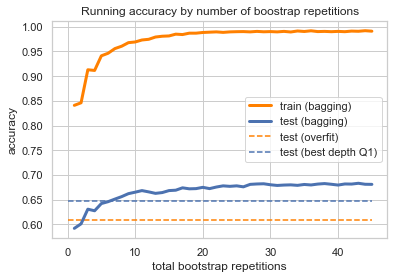

In [135]:
# plot results
reps = np.arange(1,n_reps+1,1)
plt.plot(reps,train_running_correct, c=(1,.5,0), lw=3, label="train (bagging)")
plt.plot(reps,test_running_correct, c='b', lw=3, label="test (bagging)")
plt.hlines(overfit__test_acc,0,n_reps, color=(1,.5,0), linestyle='--', label="test (overfit)")
plt.hlines(test_acc,0,n_reps, color='b', linestyle='--', label="test (best depth Q1)")
plt.xlabel("total bootstrap repetitions")
plt.ylabel("accuracy")
plt.title("Running accuracy by number of boostrap repetitions")
plt.legend();

**2.5** Referring to your graph from 2.4, compare the performance of bagging against the baseline of a single depth-10 tree. Explain the differences you see.

In [107]:
# calculate tree depth 10 accuracy
tree_10 = DecisionTreeClassifier(criterion="gini", max_depth=10).fit(X_train,y_train)
tree_10_test_acc = tree_10.score(X_test, y_test)
print("tree depth 10 accuracy = {0:.3f}".format(tree_10_test_acc))

tree depth 10 accuracy = 0.622


We can see from the graph above that at a depth of 16, the test accuracy starts below 0.6 after the first repetition, which is below the test accuracy of a depth 10 tree. From Q1, we know that both depths should overfit to the training data. So it makes sense that our starting test accuracy would be lower at depth 16 since it's going to be even more overfit than a depth of 10. However, after only a few iterations, the bagging model starts to perform more accurately than the single depth 10 model. This is because we starting to average out the overfitness from the bagging model. The model has seen many more presentations of different subsets of the training data and is less likely to be fit to the structure in the data that is caused by random sampling.

**2.6** Bagging and limiting tree depth both affect how much the model overfits. Compare and contrast these two approaches. Your answer should refer to your graph in 2.4 and may duplicate something you said in your answer to 1.5.

As we said in Q1.5, limiting the tree depth will generally produce higher bias and lower variance by restricting the complexity of the model (ie. how many times we are allowed to split the data). Lower complexity means the model is less "expressive" and is less able to fit the small-scale structure of the data (possibly generated by sampling error).

Bagging produces a lower variance model by averaging over many different models. If the noise in some signal is randomly generated, we can try to estimate the true signal by sampling it a bunch and averaging over the samples. Assuming that the high model variance we observe when fitting trees of high depth to different subsets of the training data is generated by random sampling error, we can reduce the aggregate model variance by averaging. As we start to average over more samples, the model should become more stable. We can observe this process in the plot above as the bagging lines becoming progressively smoother at high bootstrap repetitions. Therefore, bagging is similar to limiting tree depth in the sense that it produces lower variance models. However, bagging is different in that it does not accomplish this at the expense of model complexity.


**2.7**: In what ways might our bagging classifier be overfitting the data? In what ways might it be underfitting?

One way in which our bagging classifier could be overfit is that the model is still just fit to the training data. Because our training data is a finite sample, there will still be some structure to the data that is generated by noise. We've reduced this effect by resampling the data set many times, but it's still an approximation. Another way in which it could be overfit is the ordering of the features among the nodes. For example, it may be choosing the same predictor for the top node in most/all trees.

One way in which the classifier could be underfit is that the depth of the underlying models may not be enough to capture the real structure of the data. We could try to address this by fitting bagging models at many depths and exploring accuracy as a function of depth.

<div class="exercise"> <b> Question 3: Random Forests [15 pts]</b> </div>

Random Forests are closely related to the bagging model we built by hand in question 2. In this question we compare our by-hand results with the results of using `RandomForestClassifier` directly.

**3.1** Fit a `RandomForestClassifier` to the original `X_train` data using the same tree depth and number of trees that you used in Question 2.2. Evaluate its accuracy on the test set.

In [129]:
# initialize classifier with the settings above and report test accuracy
rf_clf = RandomForestClassifier(n_estimators=45, max_depth=overfit_depth).fit(X_train,y_train)
rf_train_acc = rf_clf.score(X_train,y_train)
rf_test_acc = rf_clf.score(X_test,y_test)
print("Random Forest test acc = {0:.3f}".format(rf_test_acc))

Random Forest test acc = 0.694


The accuracy is comparable but slightly better for the random forest model.

**3.2** For each of the decision trees you fit in the bagging process, how many times is each feature used at the top node? How about for each tree in the random forest you just fit? What about the process of training the Random Forest causes this difference? What implication does this observation have on the accuracy of bagging vs Random Forest?

**Hint**: A decision tree's top feature is stored in `model.tree_.feature[0]`. A random forest object stores its decision trees in its `.estimators_` attribute.

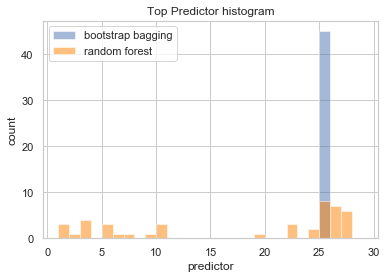

In [124]:
# get top predictors
bs_top_predictors = [tree.tree_.feature[0] for tree in bs_trees]
rf_top_predictors = [tree.tree_.feature[0] for tree in rf_clf.estimators_]

# create histogram
bins = np.arange(1,X_train.shape[1]+2,1)
plt.hist(bs_top_predictors, bins=bins, color='b', alpha=0.5, label="bootstrap bagging")
plt.hist(rf_top_predictors, bins=bins, color=(1,.5,0), alpha=0.5, label="random forest")
plt.xlabel("predictor")
plt.ylabel("count")
plt.title("Top Predictor histogram")
plt.legend();

As we can see from the plot above, the bagging approach uses the 25th predictor for the top node in every single model. Random forest shows considerably more variation, although some predictors are clearly selected more frequently than others (eg. predictor 25). The training process of random forest selects a random subset of the features to use to train each estimator. The plot above shows that predictor 25 was likely only selected as a training feature in roughly 8 of the estimators. This mechanism makes the random forest less likely to be overfit, which is likely to improve the accuracy on the test set. 

**3.3**: Make a table of the training and test accuracy for the following models:

- Single tree with best depth chosen by cross-validation (from Question 1)
- A single overfit tree trained on all data (from Question 2, using the depth you chose there)
- Bagging 45 such trees (from Question 2)
- A Random Forest of 45 such trees (from Question 3.1)

(This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.)

What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance trade-off.

In [143]:
# define accuracies
all_test_acc = np.array([test_acc, overfit__test_acc, bag_test_acc, rf_test_acc]).reshape(-1,1)
all_train_acc = np.array([train_acc, overfit__train_acc, bag_train_acc, rf_train_acc]).reshape(-1,1)
clf_name = ["singe_best_tree","overfit_tree","bagging_45_tree","random_forest_45_tree"]

# intiialize dataframe
acc_df = pd.DataFrame(columns=["train_acc","test_acc"], index=clf_name, data=np.hstack((all_train_acc,all_test_acc)))
acc_df

,train_acc,test_acc
singe_best_tree,0.6812,0.6482
overfit_tree,0.9900,0.6080
bagging_45_tree,0.9908,0.6810
random_forest_45_tree,0.9990,0.6936


It makes sense that the single best depth tree has very similar train/test accuracies. At a depth of 5, the tree is not expressive enough to overfit the training data. This model is high bias, low-variance. The high bias part means it's not very accurate (which we see particularly in the training accuracy). The effect of the low variance can be observed in the consistency in the accuracy. 

The remaining trees are all fit at a depth of 16, which means they are likely to perform well on the training data due to their high complexity. The overfit tree is a low bias, high variance model. The low bias part we can see in the high training accuracy. The high variance is reflected in the large disparity between training and test accuracy for the model. This model has a very low test accuracy because it only sees one presentation of the training data and therefore much of the complexity of the tree is used to capture the sampling noise in the training data.

The bagging and random forest models both employ strategies that attempt to find a good compromise between bias and variance. As discussed in previous questions, bootstrap resampling allows us to achieve lower variance even though we are fitting very complex models to the data. The complexity of these models is reflected in the high training accuracy (ie. low bias). The lower variance can be observed in the relatively smaller disparity between train and test accuracies (as compared to the overfit tree). As mentioned in the previous question, the random feature subset selection in random forest should produce a lower variance model than just through bagging alone. This is reflected in the slightly higher test accuracy of the random forest model.

<div class="exercise"> <b> Question 4: Boosting [15 pts]</b> </div>

In this question we explore a different kind of ensemble method, boosting, where each new model is trained on a dataset weighted towards observations that the current set of models predicts incorrectly. 

We'll focus on the AdaBoost flavor of boosting and examine what happens to the ensemble model's accuracy as the algorithm adds more predictors to the ensemble.

**Answers**

**4.1** We'll motivate AdaBoost by noticing patterns in the errors that a single classifier makes. Fit `tree1`, a decision tree with depth 3, to the training data. For each predictor, make a plot that compares two distributions: the values of that predictor for examples that `tree1` classifies correctly, and the values of that predictor for examples that `tree1` classifies incorrectly. Do you notice any predictors for which the distributions are clearly different?

*Hints*:
- If you have `fig, axs = plt.subplots(...)`, then `axs.ravel()` gives a list of each plot in reading order.
- [`sns.kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) takes `ax` and `label` parameters.

C:\Users\winsl0w\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


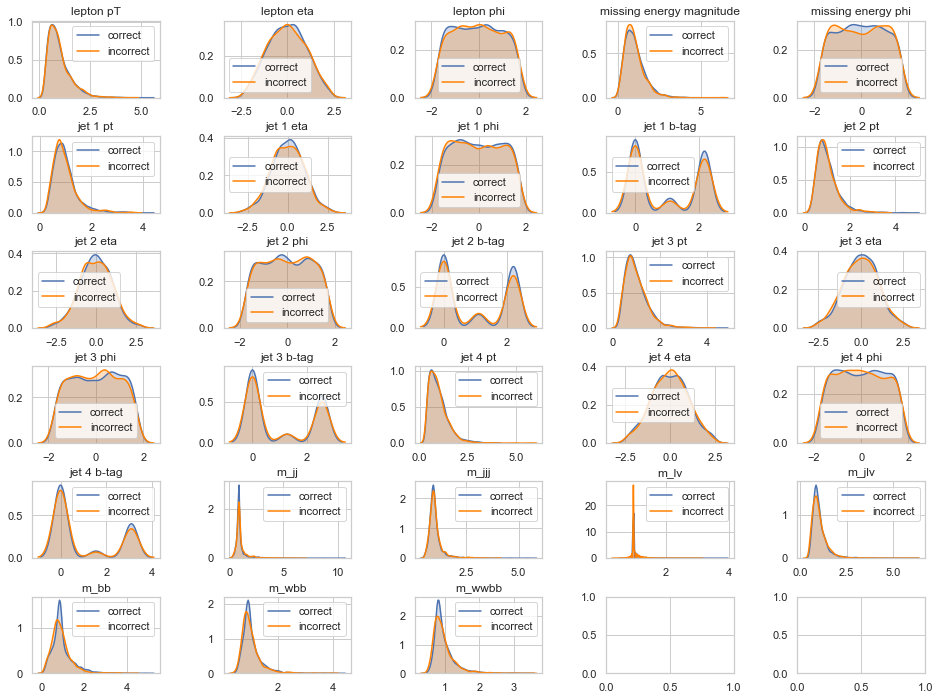

In [209]:
# fit tree of depth 3
tree_3 = DecisionTreeClassifier(criterion="gini", max_depth=3).fit(X_train,y_train)
tree_3_pred = tree_3.predict(X_train)
is_correct = tree_3_pred == y_train
pred_labels = data_train.columns

# calculate subplot dimensions
n_pred = X_train.shape[1]
n_rows = np.ceil(np.sqrt(n_pred)).astype(int)
n_cols = np.ceil(n_pred/nr).astype(int)

# initialize subplots
fig, axs = plt.subplots(nrows=nr,ncols=nc, figsize=(16,12));
plt.subplots_adjust(hspace=.5, wspace=.5)
all_ax = axs.ravel()

# iterate over predictors
for i in range(n_pred):
    
    # get subset of the data with correct/incorrect predictions
    x_correct = X_train[is_correct,i]
    x_incorrect = X_train[~is_correct,i]
    
    # plot distributions
    ax = all_ax[i]
    sns.kdeplot(x_correct, ax=ax, color='b', shade=True, label="correct")
    sns.kdeplot(x_incorrect, ax=ax, color=(1,.5,0), shade=True, label="incorrect")
    ax.set_title(pred_labels[i])
    ax.legend()

Some of the distributions have peaks at slightly different locations (eg. `missing energy phi` and `jet 4 phi`), but none of the distributions are so clearly different that they have drastically different means.

**4.2** The following code attempts to implement a simplified version of boosting using just two classifiers (described below). However, it has both stylistic and functionality flaws. First, imagine that you are a grader for a Data Science class; write a comment for the student who submitted this code. Then, imagine that you're the TF writing the solutions; make an excellent example implementation. Finally, use your corrected code to compare the performance of `tree1` and the boosted algorithm on both the training and test set.

The intended functionality is the following:
1. Fit `tree1`, a decision tree with max depth 3.
2. Construct an array of sample weights. Give a weight of 1 to samples that `tree1` classified correctly, and 2 to samples that `tree1` misclassified.
3. Fit `tree2`, another depth-3 decision tree, using those sample weights.
4. To predict, compute the probabilities that `tree1` and `tree2` each assign to the positive class. Take the average of those two probabilities as the prediction probability.

In [279]:
def boostmeup():
    tree = DecisionTreeClassifier(max_depth=3)
    tree1 = tree.fit(X_train, y_train)
    sample_weight = np.ones(len(X_train))
    q = 0
    for idx in range(len(X_train)):
        if tree1.predict([X_train[idx]]) != y_train[idx]:
            sample_weight[idx] = sample_weight[idx] * 2
            q = q + 1
    print("tree1 accuracy:", q / len(X_train))
    tree2 = tree.fit(X_train, y_train, sample_weight=sample_weight)
    
# Train
    q = 0
    for idx in range(len(X_train)):
        t1p = tree1.predict_proba([X_train[idx]])[0][1]
        t2p = tree2.predict_proba([X_train[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_train))

# Test
    q = 0
    for idx in range(len(X_test)):
        t1p = tree1.predict_proba([X_test[idx]])[0][1]
        t2p = tree2.predict_proba([X_test[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_test))

boostmeup()

tree1 accuracy: 0.3582
Boosted accuracy: 0.0008
Boosted accuracy: 0.002


The `boostmeup` function has several stylistic and functional issues:

<u>Stylistic</u>
- needs a summary description of the function and its inputs and outputs
- needs more descriptive comments throughout
- needs more descriptive variable names (eg. q, m)
- repetitions of code such as len(X_train) could be assigned to something more readable at the top of the function (eg. n_observations)
- variable names such as `tree1` and `tree2` could be combined into a single list (eg. trees)
- function name isn't very descriptive
- `if x == True:` is the same as `if x:`
- increments can be written `q+=1`


<u>Functional</u>
- Accuracy is generally calculated as the fraction inaccurate rather than fraction accurate
- Accuracy calculation inaccurately resets running count of accurate predictions `q` to zero in case statements.
- Functions should have clearly defined inputs and outputs, this function has neither. Good inputs for this function would include `X_train`, `y_train`, `max_depth` (or `tree`), `learning_rate` and `sample_weight`.
- Function is not defined flexibly enough to allow additional trees to be built iteratively on the error.
- The if / else case structure is unnecessarily complicated (eg. the case for q = q + 0 is extraneous) and can generally be replaced with logical operations and numpy functions.
- The first if statement is improperly indented
- The function definition and function call should be separated into different cells
- The code for the boosted accuracy is repeated for train and test. The same code could be used to do the calculation twice.

My personal preference is to split up the adaboost training and model accuracy reporting into separate functions. So I'm going to do that.

In [231]:
# perform ada-boosting on data
def adaboost(x_train, y_train, max_depth=3, learning_rate=2, sample_weights=None, n_boosts=1):
    """
    Inputs
        x_train - (n_samples x n_predictors) array of predictor training data
        y_train - (n_samples) array of training response data
        max_depth - (scalar) maximum tree depth for decision tree models
        learning_rate - (scalar) amount to scale sample weights for incorrect predictions
        sample_weights - (n_samples) array of sample importance weights
        n_boosts- (scalar) number of trees to fit
    Outputs
        boosted_trees - (n_boosts+1) list of tree models fit on sample weights 
    """
    
    # define number of samples and placeholder for accuracies and trees
    n_samples = x_train.shape[0]
    boosted_trees = []
    
    # define default sample weights to be one if none provided
    if sample_weights is None:
        sample_weights = np.ones(n_samples)
    
    # iterate over boostings
    for i in range(n_boosts+1):
        
        # initialize new tree with sample weights and add to tree list
        tree = DecisionTreeClassifier(max_depth=max_depth)
        tree = tree.fit(x_train, y_train, sample_weight=sample_weights)
        boosted_trees.append(tree)
        
        # calculate prediction accuracy
        pred_incorrect = tree.predict(x_train) != y_train 
        
        # update sample weights to weight inaccurate predictions by the learning rate
        sample_weights[pred_incorrect] = sample_weights[pred_incorrect]*learning_rate      
    
    return(boosted_trees)

In [357]:
def boosted_accuracy(boosted_trees, X, y):
    """
    Inputs
        boosted_trees - (n_boosts+1) list of tree models fit on sample weights
        X - (n_samples x n_predictors) array of predictor data
        y - (n_samples) array of response data
    Outputs
        accuracy - (scalar) accuracy of average prediction across all trees
    """
    # get probability of class 1 (True) from all trees in the model
    all_predictions = np.array([tree.predict_proba(X)[:,1] for tree in boosted_trees])
    
    # compute and threshold the mean probability for each observation and overall accuracy
    avg_prediction = all_predictions.mean(0) > 0.5
    accuracy = (avg_prediction == y).sum()/y.shape[0]
    return(accuracy)

Now let's test the functions out.

In [359]:
# initialize ada-boosted trees
boosted_trees = adaboost(X_train, y_train, n_boosts=10)

# caluclate accuracy
baseline_train_acc = (boosted_trees[0].predict(X_train)==y_train).sum()/y_train.shape[0]
baseline_test_acc = (boosted_trees[0].predict(X_test)==y_test).sum()/y_test.shape[0]
boosted_train_acc = boosted_accuracy(boosted_trees, X_train, y_train)
boosted_test_acc = boosted_accuracy(boosted_trees, X_test, y_test)

print("baseline tree: train_acc = {0:.3f}, test_acc={1:.3f}".format(baseline_train_acc,baseline_test_acc))
print("boosted model: train_acc = {0:.3f}, test_acc={1:.3f}".format(boosted_train_acc,boosted_test_acc))

baseline tree: train_acc = 0.642, test_acc=0.644
boosted model: train_acc = 0.697, test_acc=0.670


**4.3** Now let's use the sklearn implementation of AdaBoost: Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth 3 as the base learner and a learning rate 0.05, and run the boosting for 800 iterations. Make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.

*Hint*: The `staged_score` method provides the accuracy numbers you'll need. You'll need to use `list()` to convert the "generator" it returns into an ordinary list.

In [371]:
# initialize base decision tree and AdaBoost classifier with the above parameters
n_est = 800
base_tree = DecisionTreeClassifier(max_depth=3)
ada_tree = AdaBoostClassifier(base_estimator=base_tree, n_estimators=n_est, learning_rate=0.05)

# fit tree and record accuracies
ada_tree = ada_tree.fit(X_train, y_train)
ada_train_acc = list(ada_tree.staged_score(X_train, y_train))
ada_test_acc = list(ada_tree.staged_score(X_test, y_test))

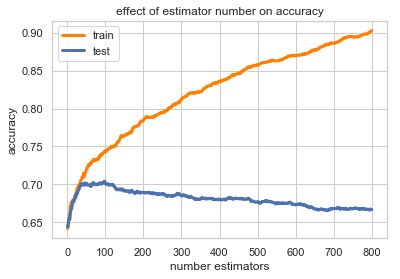

In [373]:
# plot accuracies
all_est = np.arange(1,n_est+1,1)
plt.plot(all_est, ada_train_acc, c=(1,.5,0), lw=3, label="train")
plt.plot(all_est, ada_test_acc, c='b', lw=3, label="test")
plt.xlabel("number estimators")
plt.ylabel("accuracy")
plt.title("effect of estimator number on accuracy")
plt.legend();

**4.4** Repeat the plot above for a base learner with depth of (1, 2, 3, 4). What trends do you see in the training and test accuracy?

(It's okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.)

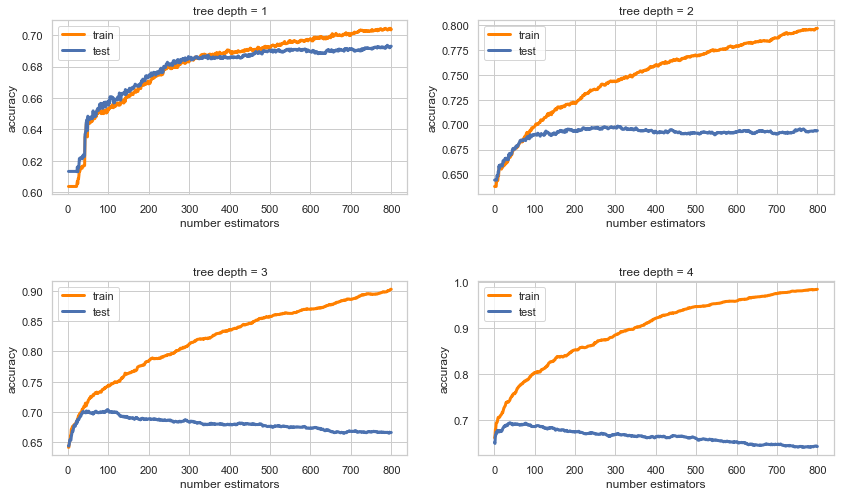

In [377]:
# initialize base decision tree and AdaBoost classifier with the above parameters
n_est = 800
depths = [1,2,3,4]
ada_train_accuracies = np.empty((n_est,len(depths)), dtype=float)
ada_test_accuracies = np.empty((n_est,len(depths)), dtype=float)

# initialize fig
plt.figure(figsize=(14,8))

# iterate over depths
for i, depth in enumerate(depths):
    # fit tree at current depth
    base_tree = DecisionTreeClassifier(max_depth=depth)
    ada_tree = AdaBoostClassifier(base_estimator=base_tree, n_estimators=n_est, learning_rate=0.05)

    # fit tree and record accuracies
    ada_tree = ada_tree.fit(X_train, y_train)
    ada_train_accuracies[:,i] = np.array(list(ada_tree.staged_score(X_train, y_train)))
    ada_test_accuracies[:,i] = np.array(list(ada_tree.staged_score(X_test, y_test)))
    
    # plot results
    plt.subplot(2,2,i+1)
    plt.plot(all_est, ada_train_accuracies[:,i], c=(1,.5,0), lw=3, label="train")
    plt.plot(all_est, ada_test_accuracies[:,i], c='b', lw=3, label="test")
    plt.xlabel("number estimators")
    plt.ylabel("accuracy")
    plt.title("tree depth = {}".format(depth))
    plt.legend();
    
plt.subplots_adjust(hspace=0.5)

The training accuracy at each depth tends to increase with increasing number of estimators, but the test accuracy seems to peak at some point. The train accuracies seem to increase faster and the test accuracy seems to peak faster at higher tree depths.

**4.5** Based on the plot you just made, what combination of base learner depth and number of iterations seems optimal? Why? How does the performance of this model compare with the performance of the ensembles you considered above?

In [400]:
# report max accuracies
max_acc = ada_test_accuracies.max()
r,c = np.where(ada_test_accuracies==max_acc)
print("best test accuracy: tree depth = {0}, iteration = {1}, acccuracy = {2:.3f}"\
      .format(depths[c[0]],r[0]+1,max_acc))

best test accuracy: tree depth = 3, iteration = 98, acccuracy = 0.704


The best model seems to have base depth of 3 and $\approx$100 estimators, using test accuracy as the criteria. All the models approach the maximum accuracy of about 0.7. This accuracy is comparable to the ensemble accuracy observed above but is slightly higher.

<div class="exercise"> <b> Question 5: Understanding [15 pts]</b> </div>

This question is an overall test of your knowledge of this homework's material. You may need to refer to lecture notes and other material outside this homework to answer these questions.

**5.1** How do boosting and bagging relate: what is common to both, and what is unique to each?

Boosting and bagging are have in common is that they are methods to build an ensemble of models using the same base model and underlying data set.

They differ in their underlying methodology and in the way in which they typically improve the model. Boosting fits sequential models on the data with progressive weights applied to the samples that the aggregate model classifies incorrectly. This is somewhat analagous to gradient descent in the sense that we iteratively provide the model with feedback on how it can improve. Bagging (Bootstrap Aggregating) fits models on bootstrapped samples of the training data. Both models tend to reduce model variance by building an ensemble of models. Boosting tends to reduce the bias on the training data but (as we can see from the plot above) can be prone to overfitting. Bagging does not tend to reduce the bias but is less prone to overfitting.

**5.2** Reflect on the overall performance of all of the different classifiers you have seen throughout this assignment. Which performed best? Why do you think that may have happened?

The AdaBoost model of depth 3 had the highest test accuracy (though very narrowly), but only for a particular range of estimators. In general, it's bad practice to estimate parameters on the test data. Without reporting the accuracies on a validation set rather than test set, it a bit hard to say. Assuming that that AdaBoost model is the most accurate, it's possible that this is accuracy reflects the fact that the algorithm progressively trains the model to pick up on smaller features of the data that it gets wrong.

**5.3** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?

In boosting, having too many trees means that specific models will start heavily weighting very small subsets of the data (even single points). Given enough estimators, the model will perform perfectly on the training data but will likely be very overfit. The only real concern of additional trees in bagging is computational time. Adding additional trees just means we resample the data more and the model variance gets smaller.

**5.4** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?

Bagging is embarassing parallel, because each model is fit on an independent bootstrap sample of the data. Boosting requires the models to be fit sequentially because we have to fit a model, identify which weights to update, and train a new model on the updated weights.

**5.5** Which of these techniques can be extended to regression tasks? How?

Bagging can be applied to regression trees exactly the same way we apply it to classification trees. We resample data, fit a regression tree to sample and report the ensemble output as the mean of all the individual trees. AdaBoosting cannot be applied to regression trees due to the underlying reliance of updating weights on inaccurate classification. However, a similar method (Boosting) can be applied to regression trees, which iteratively fits decision trees to the residuals of the running ensemble.

<div class="exercise"> <b> Question 6: Explaining Complex Concepts Clearly [10 pts]</b> </div>

One of the core skills of a data scientist is to be able to explain complex concepts clearly. To practice this skill, you'll make a short presentation of one of the approaches we have recently studied.

**Choose one of the following topics:**

- Decision Trees
- Random Forests
- Bagging
- Boosting
- Simple Neural Nets (like the MLP we saw in Homework 6)
- (other topics are possible, but get staff approval first)

**Make 3 slides explaining the concept.**

- Focus on **clear explanations**, NOT aesthetic beauty. Photos of pen-and-paper sketches are fine if they're legible.
- For your audience, choose **future CS109A students**.
- You may take inspiration from anywhere, but explain in **your own words** and **make your own illustrations**.


Submit your slides as a PDF and the source format (`.pptx`, Google Slides, etc.)

NOTE: If you would be okay with us using your slides for future classes (with attribution, of course), please include a note to that effect. This will not affect your grade either way.